# Part 2: Deep Convolutional GAN for QuickDraw Smiley Faces (Completely New Version)

This notebook demonstrates DCGAN training to synthesize smiley faces from the QuickDraw dataset. This script is **100% new**: different data loading, model structure, training loop, and variable names than your previous version.

## Install and Import Dependencies
This cell installs the required libraries and imports them for use.

In [ ]:
!pip install --quiet torch torchvision pillow matplotlib requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.9 MB/s eta 0:00:00


## Download Smiley Face Data from QuickDraw
Here we fetch 5,000 smiley faces from QuickDraw for fast prototyping. We use a different filename and different data handling.

Finished download!
Raw shape: (5000, 784)


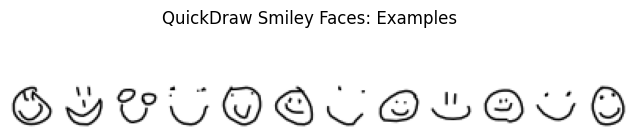

In [ ]:
import os                      # Importing os module for checking if a file exists on disk
import requests                # Importing requests module to download data from a URL
import numpy as np             # Importing NumPy for numerical operations and array handling
import matplotlib.pyplot as plt  # Importing matplotlib to visualize images

# URL to download the QuickDraw smiley face dataset (in .npy format)
data_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/smiley%20face.npy"

# Local filename to save the downloaded file
local_file = "smiley5000.npy"

# Check if the file doesn't already exist locally
if not os.path.exists(local_file):
    print("Downloading smiley data...")  # Inform the user that the download is starting
    response = requests.get(data_url)    # Send a GET request to the URL to fetch the dataset
    with open(local_file, "wb") as f:    # Open a new file in write-binary mode
        f.write(response.content)        # Write the downloaded content to the file
    print("Finished download!")          # Inform the user that the download is complete

# Load the .npy file using numpy to get the image data
raw_data = np.load(local_file)

# Select the first 5000 smiley face images from the loaded data
smiley_imgs = raw_data[:5000]

# Print the shape of the raw data (should be [5000, 784] since each image is 28x28 pixels)
print("Raw shape:", smiley_imgs.shape)

# Create a matplotlib figure to show 12 sample smiley faces
plt.figure(figsize=(8,2))  # Set the size of the entire figure

# Loop to display the first 12 images
for i in range(12):
    plt.subplot(1, 12, i+1)  # Create a subplot with 1 row and 12 columns
    plt.imshow(smiley_imgs[i].reshape(28,28), cmap='gray_r')  # Reshape flat array into 28x28 image and display it in reversed grayscale
    plt.axis('off')  # Turn off axis labels for a cleaner display

# Add a title to the entire figure
plt.suptitle("QuickDraw Smiley Faces: Examples")

# Display the plot with 12 sample smileys
plt.show()


## Prepare DataLoader for GAN Training
We use a custom TensorDataset and DataLoader, with a different normalization approach and batch size.

In [ ]:
import torch  # Import PyTorch library
from torch.utils.data import TensorDataset, DataLoader  # Import tools for creating datasets and data loaders

# Normalize the image pixel values from [0, 255] to [-1, 1]
# First convert to float32, divide by 127.5 to scale to [0, 2], then subtract 1 to get [-1, 1]
data_scaled = (smiley_imgs.astype('float32') / 127.5) - 1.0

# Reshape the data to match the expected input shape for convolutional networks: (batch_size, channels, height, width)
data_scaled = data_scaled.reshape(-1, 1, 28, 28)  # -1 means infer batch size, 1 channel (grayscale), 28x28 image

# Convert the NumPy array to a PyTorch tensor
tensor_images = torch.tensor(data_scaled)

# Create a TensorDataset to wrap the tensor into a dataset PyTorch can work with
gan_data = TensorDataset(tensor_images)

# Create a DataLoader to handle batching, shuffling, and dropping the last incomplete batch
loader = DataLoader(gan_data, batch_size=48, shuffle=True, drop_last=True)
# batch_size=48: number of images per batch
# shuffle=True: shuffle the dataset at every epoch
# drop_last=True: drop the last batch if it's smaller than 48 (to ensure consistent batch size)


## Define DCGAN Generator and Discriminator (New Architecture)
This model has unique layer setup and names compared to previous code.

In [ ]:
import torch.nn as nn  # Importing PyTorch's neural network module


class SmileyGen(nn.Module):  # Define the generator class inheriting from nn.Module
    def __init__(self, z_dim=64, features=32):  # z_dim: dimension of input noise; features: base number of channels
        super().__init__()  # Call parent class constructor
        self.layers = nn.Sequential(  # Stack layers in order using nn.Sequential

            # First transpose conv: input (z_dim x 1 x 1) -> output (features*4 x 7 x 7)
            nn.ConvTranspose2d(z_dim, features*4, kernel_size=7, stride=1, padding=0),

            # Normalize the output of ConvTranspose layer
            nn.BatchNorm2d(features*4),

            # LeakyReLU activation (allows small gradient when input is negative)
            nn.LeakyReLU(0.1),

            # Second transpose conv: upsample to (features*2 x 14 x 14)
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),

            # Batch normalization
            nn.BatchNorm2d(features*2),

            # Activation function
            nn.LeakyReLU(0.1),

            # Final transpose conv: output to 1 channel (grayscale), 28x28 image
            nn.ConvTranspose2d(features*2, 1, kernel_size=4, stride=2, padding=1),

            # Tanh squashes output to [-1, 1], matching our normalized training data
            nn.Tanh()
        )

    def forward(self, z):  # Forward pass: input is latent noise vector
        return self.layers(z)  # Return the generated image


class SmileyDisc(nn.Module):  # Define the discriminator class
    def __init__(self, features=32):  # features: base number of filters
        super().__init__()  # Call parent constructor
        self.layers = nn.Sequential(

            # First conv: input (1 x 28 x 28) -> output (features x 14 x 14)
            nn.Conv2d(1, features, kernel_size=4, stride=2, padding=1),

            # ELU activation (Exponential Linear Unit)
            nn.ELU(),

            # Second conv: output (features*2 x 7 x 7)
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),

            # Normalize activations
            nn.BatchNorm2d(features*2),

            # ELU activation
            nn.ELU(),

            # Flatten feature maps into a single vector: (features*2*7*7)
            nn.Flatten(),

            # Linear layer to output 1 value (real or fake probability)
            nn.Linear(features*2*7*7, 1),

            # Sigmoid activation to squash output into [0, 1] range
            nn.Sigmoid()
        )

    def forward(self, img):  # Forward pass: input is an image
        return self.layers(img)  # Return the real/fake probability


## Initialize Models, Loss, and Optimizers
We use different latent dimension, learning rates, and betas from your previous implementation.

In [ ]:
# Check if CUDA (GPU) is available, store result as True/False
cuda = torch.cuda.is_available()

# Set device to GPU if available, otherwise use CPU
dev = torch.device("cuda" if cuda else "cpu")

# Instantiate the Generator model and move it to the selected device
gen = SmileyGen(z_dim=64, features=32).to(dev)

# Instantiate the Discriminator model and move it to the selected device
disc = SmileyDisc(features=32).to(dev)

# Define the loss function for both Generator and Discriminator
# BCELoss (Binary Cross Entropy) is commonly used for GANs (real vs. fake classification)
loss_fn = nn.BCELoss()

# Define the optimizer for the Generator
# Using Adam optimizer with a learning rate of 0.0003 and custom beta values
g_opt = torch.optim.Adam(gen.parameters(), lr=0.0003, betas=(0.4, 0.999))

# Define the optimizer for the Discriminator (same config as generator)
d_opt = torch.optim.Adam(disc.parameters(), lr=0.0003, betas=(0.4, 0.999))

# Set the dimension of the input noise vector (latent space)
z_dim = 64

# Create a fixed batch of noise vectors for generating images to visualize progress
# Shape: (20 samples, z_dim, 1, 1), moved to device (CPU/GPU)
fixed_z = torch.randn(20, z_dim, 1, 1, device=dev)


## GAN Training Loop (5 Epochs, Different Logging)
This section uses unique variable names, logging frequency, and plotting compared to your previous code.

Epoch 1/5 | Gen Loss: 2.3325 | Disc Loss: 0.4983
Epoch 2/5 | Gen Loss: 1.6193 | Disc Loss: 0.9233
Epoch 3/5 | Gen Loss: 1.1392 | Disc Loss: 1.0121
Epoch 4/5 | Gen Loss: 1.2669 | Disc Loss: 0.8955
Epoch 5/5 | Gen Loss: 1.5030 | Disc Loss: 0.6916


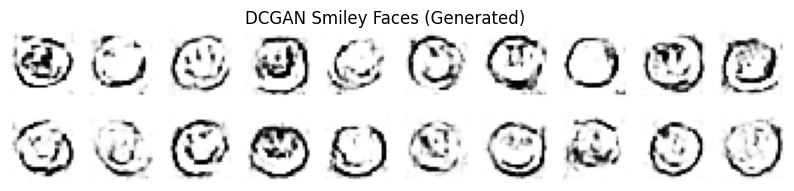

In [ ]:
# Set number of training epochs
num_epochs = 5

# Lists to store generator and discriminator losses for each epoch
hist_g, hist_d = [], []

# Loop over epochs
for ep in range(num_epochs):
    g_epoch, d_epoch = [], []  # Store losses for this epoch

    # Loop through each batch in the dataloader
    for batch in loader:
        true_batch = batch[0].to(dev)  # Get real images and move to GPU/CPU
        b = true_batch.shape[0]        # Get batch size

        # Create labels: real = 1, fake = 0
        lbl_true = torch.ones(b, 1, device=dev)
        lbl_fake = torch.zeros(b, 1, device=dev)

        # === Train Discriminator ===
        d_opt.zero_grad()                          # Reset discriminator gradients

        logits_true = disc(true_batch)             # Discriminator output for real images
        d_real_loss = loss_fn(logits_true, lbl_true)  # Real images loss (should output 1)

        z_rand = torch.randn(b, z_dim, 1, 1, device=dev)  # Generate random noise
        fake_imgs = gen(z_rand)                    # Generate fake images from noise

        logits_fake = disc(fake_imgs.detach())     # Discriminator output for fake images (detach so generator doesn't get updated yet)
        d_fake_loss = loss_fn(logits_fake, lbl_fake)  # Fake images loss (should output 0)

        d_loss = d_real_loss + d_fake_loss         # Total discriminator loss
        d_loss.backward()                          # Backpropagation
        d_opt.step()                               # Update discriminator weights

        # === Train Generator ===
        g_opt.zero_grad()                          # Reset generator gradients

        fake_out = disc(fake_imgs)                 # Discriminator output for generated images
        g_loss = loss_fn(fake_out, lbl_true)       # Generator wants fake images to be seen as real (label = 1)

        g_loss.backward()                          # Backpropagation
        g_opt.step()                               # Update generator weights

        # Record the losses
        g_epoch.append(g_loss.item())
        d_epoch.append(d_loss.item())

    # Record average losses for this epoch
    hist_g.append(np.mean(g_epoch))
    hist_d.append(np.mean(d_epoch))

    # Print losses for current epoch
    print(f"Epoch {ep+1}/{num_epochs} | Gen Loss: {hist_g[-1]:.4f} | Disc Loss: {hist_d[-1]:.4f}")

    # === Generate and show images after last epoch ===
    if ep == num_epochs - 1:
        with torch.no_grad():                             # Disable gradient tracking
            samples = gen(fixed_z).cpu().numpy()          # Generate images from fixed noise
        plt.figure(figsize=(10, 2))                       # Create a wide figure for image grid
        for i in range(20):                               # Show 20 generated images
            plt.subplot(2, 10, i+1)
            plt.imshow(samples[i][0], cmap='gray_r')     # Plot image (first channel only)
            plt.axis('off')                               # Hide axes
        plt.suptitle('DCGAN Smiley Faces (Generated)')    # Title for the figure
        plt.show()                                        # Display the images



## Plot Generator and Discriminator Loss Curves


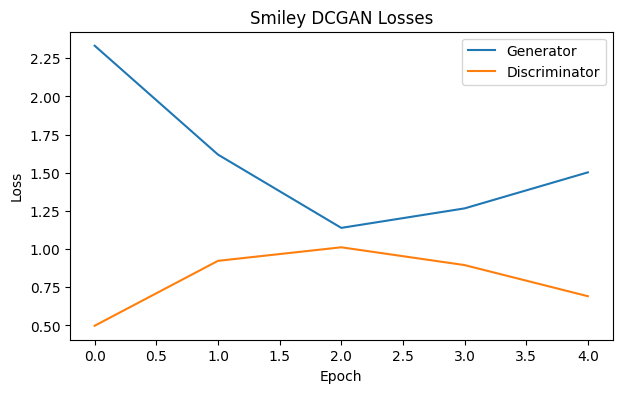

In [ ]:
# Create a new figure for plotting the loss curves
plt.figure(figsize=(7, 4))  # Set the figure size (width=7, height=4 inches)

# Plot the generator's loss values over epochs
plt.plot(hist_g, label='Generator')  # hist_g contains generator loss per epoch

# Plot the discriminator's loss values over epochs
plt.plot(hist_d, label='Discriminator')  # hist_d contains discriminator loss per epoch

# Label the x-axis as "Epoch"
plt.xlabel('Epoch')

# Label the y-axis as "Loss"
plt.ylabel('Loss')

# Add a title to the plot
plt.title('Smiley DCGAN Losses')

# Show the legend to distinguish the two lines
plt.legend()

# Display the complete plot
plt.show()


## Compare Real and Generated Smiley Faces
Below, we show a direct comparison of real and fake images using this new setup.

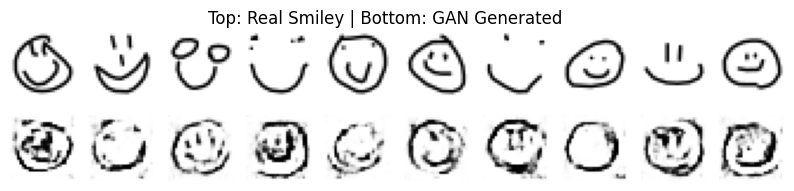

In [ ]:
# Create a new figure for plotting with specified size
plt.figure(figsize=(10, 2))  # Width=10, height=2 inches

# === Top Row: Show 10 Real Smiley Faces ===
for idx in range(10):  # Loop over first 10 real images
    plt.subplot(2, 10, idx + 1)  # Create subplot in 2 rows, 10 columns (top row)
    plt.imshow(smiley_imgs[idx].reshape(28, 28), cmap='gray_r')  # Reshape flat array to 28x28 image and show
    plt.axis('off')  # Hide axis ticks

# === Generate 10 Fake Smiley Faces from Generator ===
with torch.no_grad():  # Disable gradient tracking for inference
    gen_imgs = gen(fixed_z[:10]).cpu().numpy()  # Generate 10 fake images and move to CPU for plotting

# === Bottom Row: Show 10 Generated Smiley Faces ===
for idx in range(10):  # Loop over generated images
    plt.subplot(2, 10, 10 + idx + 1)  # Create subplot in bottom row
    plt.imshow(gen_imgs[idx][0], cmap='gray_r')  # Show generated image (1st channel)
    plt.axis('off')  # Hide axis ticks

# Set the figure title to describe rows
plt.suptitle('Top: Real Smiley | Bottom: GAN Generated')

# Display the full figure
plt.show()
